<a href="https://colab.research.google.com/github/Stavroskiig/SVM-CIFAR-10/blob/main/NN_2nd_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

2η Υποχρεωτική Εργασία


---
* **Στόχος**:
Ζητούμενο της εργασίας είναι να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα **Support Vector Machine**. Το SVM αυτό θα εκπαιδευτεί για να επιλύει το πρόβλημα του διαχωρισμού 2 κλάσεων που υπάρχουν στο **CIFAR-10**.

* **Γλώσσα**:
Επιλέγω να εργαστώ σε Python χρησιμοποιώντας την βιβλιοθήκη `PyTorch` για την ανάπτυξη των νευρωνικών μοντέλων, η οποία είναι αρκετά δημοφιλής στην ερευνητική και εκπαιδευτική κοινότητα.

* **Βάση Δεδομένων**:
Για την εκπαίδευση και την κατηγοριοποίηση αποφάσισα να χρησιμοποιήσω την βάση δεδομένων CIFAR-10 που υπάρχει στην παρακάτω διεύθυνση:
https://www.cs.toronto.edu/~kriz/cifar.html


---



# Προεπεξεργασία του CIFAR-10

Παίρνω το dataset από την keras. Βεβαίως απαιτείται πρώτα να εισάγω την TensorFLow.



In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

Αυτό μου επιστρέφει:
* **x_train**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (50000, 32, 32, 3), που περιέχουν τα δεδομένα εκπαίδευσης (train). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_train**: uint8 NumPy πίνακας ετικετών (labels) (ακέραιοι του εύρους 0-9) με shape (50000, 1) για τα δεδομένα εκπαίδευσης (train).

* **x_test**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (10000, 32, 32, 3), που περιέχουν τα δεδομένα δοκιμής (test). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_test**: uint8 NumPy πίνακας ετικετών (ακέραιοι στο εύρος 0-9) με shapes (10000, 1) για τα δεδομένα δοκιμής (test).

Θα δω τα shapes των συνόλων. Τα `x` σύνολα περιλαμβάνουν τις εικόνες, ενώ τα `y` τις ετικέτες.

In [2]:
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


* Τα `x_train` και `x_test` έχουν το shape: (πλήθος εικόνων, ύψος, πλάτος, πλήθος καναλιών).
* Τα `y_train` και `y_test` είναι 2D πίνακες με shape: (πλήθος εικόνων, 1)

Τώρα θέλω να διατηρήσω μόνο δύο κλάσεις από το σύνολο δεδομένων CIFAR-10. Για αυτό θα φιλτράρω τα δεδομένα με βάση τις κλάσεις που θέλετε να κρατήσω. Επιλέγω τα αεροπλάνα (index 0) και τα πλοία (index 8).

In [3]:
desired_classes = [0, 8]

Ορίζω την συνάρτηση φιλτραρίσματος, η οποία παίρνει ως παραμέτρους ένα σύνολο x και τις κλάσεις που έχω επιλέξει. Το tf.equal επιστρέφει έναν boolean τένσορα με την τιμή True όπου η κλάση του παραδείγματος ταιριάζει με τις επιλεγμένες κλάσεις, ενώ False στις υπόλοιπες.

In [4]:
import numpy as np

def filter_dataset(x, y, desired_classes):
    y = y.flatten()
    train_mask = np.isin(y, desired_classes)
    x_filtered = x[train_mask]
    y_filtered = y[train_mask]
    return x_filtered, y_filtered

In [11]:
x_train_filtered, y_train_filtered = filter_dataset(x_train, y_train, desired_classes)
x_test_filtered, y_test_filtered = filter_dataset(x_test, y_test, desired_classes)

In [6]:
print(x_train.shape, x_train_filtered.shape)
print(y_train.shape, y_train_filtered.shape)

print(x_test.shape, x_test_filtered.shape)
print(y_test.shape, y_test_filtered.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1) (10000,)
(10000, 32, 32, 3) (2000, 32, 32, 3)
(10000, 1) (2000,)


Μετατρέπω τα σύνολα σε `float32`.

In [12]:
x_train_filtered, x_test_filtered = np.array(x_train_filtered, dtype=np.float32), np.array(x_test_filtered, dtype=np.float32)

Θα κάνω flatten τις εικόνες από 3D σε διανύσματα 1D.

In [13]:
number_features = 3072

x_train_filtered = x_train_filtered.reshape([-1, number_features])
x_test_filtered = x_test_filtered.reshape([-1, number_features])

print("x_train:", x_train_filtered.shape, "x_test:", x_test_filtered.shape)

x_train: (10000, 3072) x_test: (2000, 3072)


Θα τις κανονικοποιήσω στο εύρος [0,1].

In [14]:
x_train_filtered = x_train_filtered/255.0
x_test_filtered = x_test_filtered/255.0

Κρατώ τον αριθμό των κλάσεων και των υπερκλάσεων για το μέλλον.

In [15]:
number_classes = 2
number_features = 3072

In [17]:
import time
from sklearn.decomposition import PCA

start = time.time()

pca = PCA(n_components=0.9).fit(x_train_filtered)
x_train_pca = pca.transform(x_train_filtered)
x_test_pca = pca.transform(x_test_filtered)

end = time.time()
print("PCA elapsed time: {} seconds\n".format(end - start))
print("Extracted {} features from the original {}.".format(x_train_pca.shape[1], x_train_filtered.shape[1]))
print("Cumulative explained variation for {} principal components: {:.2%}".format(x_train_pca.shape[1], np.sum(pca.explained_variance_ratio_)))

PCA elapsed time: 27.985271453857422 seconds

Extracted 76 features from the original 3072.
Cumulative explained variation for 76 principal components: 90.07%


Κρατώντας μόλις 99 features από τα 3072, δηλαδή το 2.47%, καταφέρνω να κρατήσω περισσότερο από το 90% της πληροφορίας.

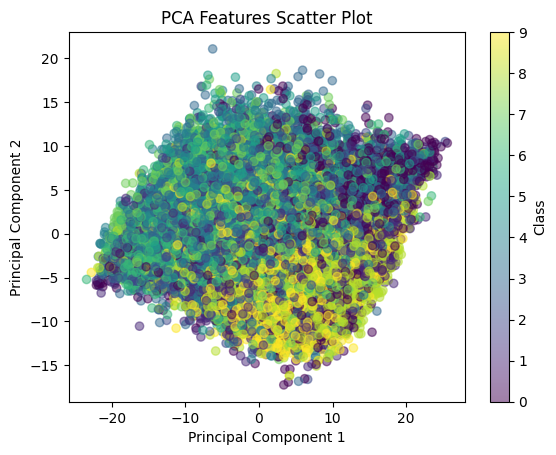

In [20]:
import matplotlib.pyplot as plt

# Assuming x_train_pca is your PCA-transformed data

# Scatter plot
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train.flatten(), cmap='viridis', alpha=0.5)
plt.title('PCA Features Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Class')
plt.show()
